# Homework Starter — Stage 14: Deployment & Monitoring

Use this template to draft your reflection and (optionally) sketch a dashboard.

## 1) Reflection (200–300 words)

1) Risks if deployed  
The primary risks are data drift (feature distribution shift and changing missingness patterns), concept drift (target relationship changes over time), and mis-specified missing-data handling that induces bias. Operational risks include latency spikes, partial failures during batch scoring, model-version confusion, and resource exhaustion. Security and privacy risks arise if input validation is weak or PII is logged. Business risks include degraded decision quality for key subgroups (uneven errors) and unforeseen cost impacts from false positives/negatives.

2) Exact metrics to monitor (Data / Model / System / Business)  
- Data: freshness_minutes, null_rate per feature, schema_hash, per-feature mean/std and PSI (population stability index), imputation_rate.  
- Model: rolling MAE (or AUC) over sliding window, calibration_error (ECE), prediction distribution (mean/confidence), feature-importance drift, sample coverage.  
- System: p95_latency_ms, error_rate (5xx and uncaught exceptions), CPU% / memory%, queue_length, restart_count.  
- Business: approval_rate (or acceptance), bad_rate (post-hoc error rate), cost_per_decision, conversion/revenue impact.  
For each metric define SLA thresholds and alert severity (e.g., p95_latency > 250ms = P1).

3) Ownership & handoff process  
Data owner (analytics) owns data quality alerts and schema changes. ML owner (model author) owns model performance alerts, retraining triggers, and model artifact versioning. SRE/DevOps owns system metrics, deployment, and on-call handling. Product owner tracks business KPIs and escalation. Handoffs: deliver model artifact (with metadata), preprocessing code, test vectors, CI/CD pipeline, and runbook. Weekly syncs for the first 4 weeks post-deploy and monthly review thereafter.

## 2) Optional: Dashboard Sketch
Describe panels and key charts. You can also attach an image file in your repo (png/pdf).

In [ ]:
# dataset loaded
from pathlib import Path
from datetime import datetime
import random, time, csv, json, math, statistics
import matplotlib.pyplot as plt

BASE = Path('stage14/tmp/stage14_demo')
BASE.mkdir(parents=True, exist_ok=True)

# 指标文件路径 / Metrics CSV path
METRICS_CSV = BASE / 'metrics.csv'
if not METRICS_CSV.exists():
    with METRICS_CSV.open('w', newline='') as f:
        w = csv.writer(f)
        # 指标列：时间戳、名称、数值、层级、模型版本、窗口、上下文 / Columns
        w.writerow(['ts','name','value','layer','model_version','window','context'])
print(f'Writing metrics to: {METRICS_CSV}')

Writing metrics to: stage14\tmp\stage14_demo\metrics.csv


In [3]:
def log_metric(name, value, *, layer, model_version='v1', window='1m', **ctx):
    """
    Append a metric row to CSV.
    Args:
      - name: metric name
      - value: metric value
      - layer: monitoring layer
      - model_version: model version
      - window: aggregation window
      - **ctx: additional context
    """
    row = [
        datetime.utcnow().isoformat(timespec='seconds') + 'Z',
        name,
        float(value),
        layer,
        model_version,
        window,
        json.dumps(ctx)
    ]
    with METRICS_CSV.open('a', newline='') as f:
        csv.writer(f).writerow(row)
    return row

# quick smoke test
log_metric('job_success', 1.0, layer='system', window='1d', job='nightly_batch')


C:\Users\noven\AppData\Local\Temp\ipykernel_50360\2069563982.py:13: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  datetime.utcnow().isoformat(timespec='seconds') + 'Z',


['2025-08-28T18:55:48Z',
 'job_success',
 1.0,
 'system',
 'v1',
 '1d',
 '{"job": "nightly_batch"}']

C:\Users\noven\AppData\Local\Temp\ipykernel_50360\2069563982.py:13: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  datetime.utcnow().isoformat(timespec='seconds') + 'Z',


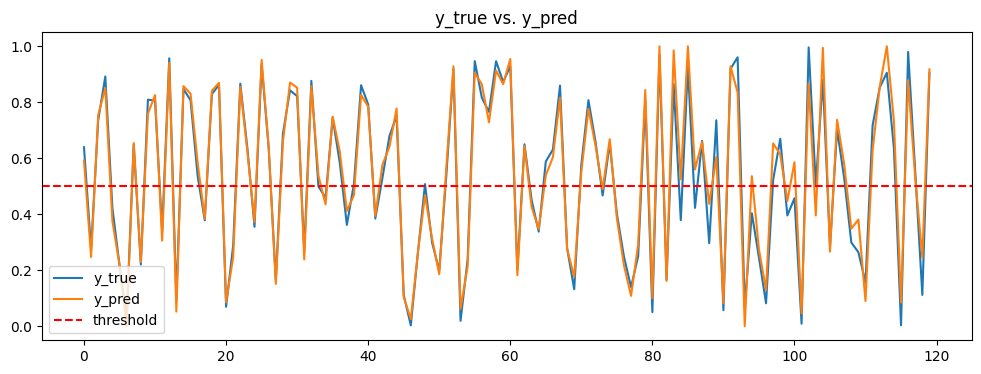

In [10]:
random.seed(42)
y_true, y_pred = [], []
for t in range(120):
    y = random.random()  # 真实值 ∈ [0,1] / ground truth in [0,1]
    # 在 t>80 后逐步劣化的模型 / model degrades after t>80
    noise = 0.05 if t <= 80 else 0.15
    pred = min(1.0, max(0.0, y + random.uniform(-noise, noise)))
    y_true.append(y); y_pred.append(pred)
    if t >= 19:
        window_true = y_true[t-19:t+1]
        window_pred = y_pred[t-19:t+1]
        mae = sum(abs(a-b) for a,b in zip(window_true, window_pred))/20
        # 滚动 MAE 作为模型层指标 / rolling MAE as model metric
        row = log_metric('rolling_mae', mae, layer='model', window='20obs', step=t)
        # 伪造延迟（毫秒）/ fake latency (ms)
        latency = random.randint(60, 160) if t <= 80 else random.randint(120, 300)
        log_metric('p95_latency_ms', latency, layer='system', window='1m', step=t)
row[:3]

plt.figure(figsize=(12,4))
plt.title('y_true vs. y_pred')
plt.plot(y_true, label='y_true')
plt.plot(y_pred, label='y_pred')
plt.axhline(0.5, color='red', linestyle='--', label='threshold')
plt.legend()
import os
os.makedirs('stage14/handoff', exist_ok=True)
plt.savefig('stage14/handoff/metrics.png')

In [5]:
# Optional helper: simple structure to list metrics
monitoring = {
    'data': ['freshness_minutes', 'null_rate', 'schema_hash'],
    'model': ['rolling_mae_or_auc', 'calibration_error'],
    'system': ['p95_latency_ms', 'error_rate'],
    'business': ['approval_rate', 'bad_rate']
}
monitoring

{'data': ['freshness_minutes', 'null_rate', 'schema_hash'],
 'model': ['rolling_mae_or_auc', 'calibration_error'],
 'system': ['p95_latency_ms', 'error_rate'],
 'business': ['approval_rate', 'bad_rate']}